In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns
import ipaddress as ip
import tldextract
import pickle as pkl
import sklearn.ensemble as ensembleLearning
import sklearn

from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn import svm
from sklearn import linear_model
from sklearn import tree
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn import cross_validation

from urllib.parse import urlparse
from __future__ import division

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
# Original Dataset with Domain + Label with other features value
data = pd.read_csv('DataSet/PhishLegitimateDataSet.csv')
data.head()

,domain,ranking,mld_res,mld.ps_res,card_rem,ratio_Rrem,ratio_Arem,jaccard_RR,jaccard_RA,jaccard_AR,jaccard_AA,jaccard_ARrd,jaccard_ARrem,label
0,nobell.it/70ffb52d079109dca5664cce6f317373782/...,10000000,1.0,0.0,18,107.611111,107.277778,0.0,0.0,0.0,0.0,0.8,0.795729,1.0
1,www.dghjdgf.com/paypal.co.uk/cycgi-bin/webscrc...,10000000,0.0,0.0,11,150.636364,152.272727,0.0,0.0,0.0,0.0,0.0,0.768577,1.0
2,serviciosbys.com/paypal.cgi.bin.get-into.herf....,10000000,0.0,0.0,14,73.500000,72.642857,0.0,0.0,0.0,0.0,0.0,0.726582,1.0
3,mail.printakid.com/www.online.americanexpress....,10000000,0.0,0.0,6,562.000000,590.666667,0.0,0.0,0.0,0.0,0.0,0.859640,1.0
4,thewhiskeydregs.com/wp-content/themes/widescre...,10000000,0.0,0.0,8,29.000000,24.125000,0.0,0.0,0.0,0.0,0.0,0.748971,1.0


In [3]:
# Get domain and label only : 1st way
header = ['domain', 'label']
# Export to new CSV
data.to_csv('DataSet/PhishLegitimateDataSet_Cleaned1.csv', columns = header, index = False)

# Get domain and label only : 2nd way
dfRequired = data[['domain', 'label']]
# Export to new CSV
dfRequired.to_csv('DataSet/PhishLegitimateDataSet_Cleaned2.csv', index = False)
dfRequired.head()

,domain,label
0,nobell.it/70ffb52d079109dca5664cce6f317373782/...,1.0
1,www.dghjdgf.com/paypal.co.uk/cycgi-bin/webscrc...,1.0
2,serviciosbys.com/paypal.cgi.bin.get-into.herf....,1.0
3,mail.printakid.com/www.online.americanexpress....,1.0
4,thewhiskeydregs.com/wp-content/themes/widescre...,1.0


In [4]:
# Helper Functions
def get_f1_score(Y_test, Y_predict, title):
    test_size = len(Y_test)
    score = 0
    
    for i in range(test_size):
        if Y_predict[i] == Y_test[i]:
            score += 1
            
    print('Got %s out of %s' % (score, test_size))
    print('f1 = %.2f' % (f1_score(Y_test, Y_predict, average = 'binary')))
    print('precision = %.2f' % (precision_score(Y_test, Y_predict, average = 'binary')))
    print('recall = %.2f' % (recall_score(Y_test, Y_predict, average = 'binary')))
    print('accuracy = %.2f' % (accuracy_score(Y_test, Y_predict)))

    bar_width = 0.20
    opacity = 0.4
    error_config = {'ecolor': '0.3'}
    index = np.arange(1)

    fig, ax = plt.subplots()

    ax.bar(index, f1_score(Y_test, Y_predict, average = 'binary'), bar_width,
           alpha = opacity, color = 'b',
           error_kw = error_config,
           label = 'F Score')
    ax.bar(index + bar_width * 1, precision_score(Y_test, Y_predict, average = 'binary'), bar_width,
           alpha = opacity, color = 'r',
           error_kw = error_config,
           label = 'Precision')
    ax.bar(index + bar_width * 2, recall_score(Y_test, Y_predict, average = 'binary'), bar_width,
           alpha = opacity, color = 'g',
           error_kw = error_config,
           label = 'Recall')
    ax.bar(index + bar_width * 3, accuracy_score(Y_test, Y_predict), bar_width,
           alpha = opacity, color = 'y',
           error_kw = error_config,
           label = 'Accuracy')
    ax.set_xlabel('Measures')
    ax.set_ylabel('Scores')
    ax.set_title(title)
    ax.tick_params(
        axis = 'x',           # changes apply to the x-axis
        which = 'both',       # both major and minor ticks are affected
        bottom = False,       # ticks along the bottom edge are off
        top = False,          # ticks along the top edge are off
        labelbottom = False)  # labels along the bottom edge are off
    ax.legend()
    fig.tight_layout()
    plt.show()

In [5]:
# Helper Functions
def get_domain_from_url(url):
    return url[:url.find('/',8)]

def get_path_from_url(url):
    return url[url.find('/',8):]

def get_length(str):
    return len(str)

def get_forward_slash_count(str):
    return str.count('/')

def get_dot_count(str):
    return str.count('.')

def get_delimeter_count(str):
    count = 0
    delim = [';', '_', '?', '=', '&']
    for each in str:
        if each in delim:
            count = count + 1
    return count

def isip(uri):
    try:
        if ip.ip_address(uri):
            return 1
    except:
        return 0
    
def get_hyphen_count(str):
    return str.count('-')

def get_at_count(str):
    return str.count('@')

def get_amp_count(str):
    return str.count('&')

# LEXICAL FEATURES
# URL Related
def get_forward_slash_count_in_url(url):
    return get_forward_slash_count(url)

def get_dot_count_in_url(url):
    return get_dot_count(url)

def get_url_length(url):
    return get_length(url)

# Domain Related
def get_forward_slash_count_in_domain(url):
    return get_forward_slash_count(get_domain_from_url(url))

def get_dot_count_in_domain(url):
    return get_dot_count(get_domain_from_url(url))

def get_domain_length(url):
    return get_length(get_domain_from_url(url))

# Path Related
def get_forward_slash_count_in_path(url):
    return get_forward_slash_count(get_path_from_url(url))

def get_dot_count_in_path(url):
    return get_dot_count(get_path_from_url(url))

def get_path_length(url):
    return get_length(get_path_from_url(url))

In [6]:
# we use this function when feature vector has label (binary) at end, and use it in conjuction with def make_np_array_XY(xy):
def make_feature_vector(from_index, url, label):
    feature_vector = []
    for i in range(len(url)):
        s = url[from_index + i]
        if len(s) > 0:
            s = str(s)
            path = urlparse(s)
            ext = tldextract.extract(s)
    
            feature = []

            #Syntatic
            feature.append(isip(ext.domain))
            feature.append(get_at_count(s))
            feature.append(get_hyphen_count(s))
            feature.append(get_amp_count(s))
            feature.append(get_delimeter_count(s))
        
            #URL Related
            feature.append(get_forward_slash_count_in_url(s))
            feature.append(get_dot_count_in_url(s))
            feature.append(get_url_length(s))

            #Sub-domain/Domain Related
            feature.append(get_forward_slash_count_in_domain(s))
            feature.append(get_dot_count_in_domain(s))
            feature.append(get_domain_length(s))

            #Path Related
            feature.append(get_forward_slash_count_in_path(s))
            feature.append(get_dot_count_in_path(s))
            feature.append(get_path_length(s))

            feature.append(len(path.netloc)) # domain name length
            feature.append(len(path.query))# number of queries
            
            feature.append(label[from_index + i])
        feature_vector.append(feature)

    return feature_vector

In [7]:
def getFeatures(url, label): 
    s = str(url)
    path = urlparse(url)
    ext = tldextract.extract(url)

    feature = []

    #Syntatic
    feature.append(isip(ext.domain))
    feature.append(get_at_count(s))
    feature.append(get_hyphen_count(s))
    feature.append(get_amp_count(s))
    feature.append(get_delimeter_count(s))

    #URL Related
    feature.append(get_forward_slash_count_in_url(s))
    feature.append(get_dot_count_in_url(s))
    feature.append(get_url_length(s))

    #Sub-domain/Domain Related
    feature.append(get_forward_slash_count_in_domain(s))
    feature.append(get_dot_count_in_domain(s))
    feature.append(get_domain_length(s))

    #Path Related
    feature.append(get_forward_slash_count_in_path(s))
    feature.append(get_dot_count_in_path(s))
    feature.append(get_path_length(s))

    feature.append(len(path.netloc)) # domain name length
    feature.append(len(path.query))# number of queries

    feature.append(label)
    return feature

In [8]:
def make_np_array_XY(xy):
    a = np.array(xy)
    x = a[:, 0:-1]
    y = a[:, -1]
    return x, y

In [9]:
from_index = 30000
to_index = 65000
cut_ratio = 0.8

In [10]:
# use subset of given dataset
dfRequired_trim = dfRequired[from_index:to_index]
dfRequired_trim.head()

,domain,label
30000,prades-consulting.com/www.paypal.fr/bd6e020e9c...,1.0
30001,arcot6.mcscsec.com/,1.0
30002,'aricilikmarketi.com/templates/estime_redberry...,1.0
30003,www.cocodelagalea.es/imagenes/www.vodafone.co....,1.0
30004,bankruptcyarmor.com/wp-includes/js/crop/www.vo...,1.0


In [11]:
# For Debugging
len(dfRequired_trim)

35000

In [12]:
# For Debugging
print(dfRequired_trim["domain"].loc[0 + from_index])

prades-consulting.com/www.paypal.fr/bd6e020e9ce0350d5ef1820fb309193f/


In [13]:
featureSet = pd.DataFrame(columns = (' is ip ',' @ count ',' - count ',' & count ',' delimeter count ',\
                                     ' url / count ',' url . count ',' url length ',\
                                     ' domain/subdomain / count ',' domain/subdomain . count ',' domain/subdomain length ',\
                                     ' path / count ',' path . count ',' path length ',\
                                     'domain name length','query count',\
                                     'label'))
#featureSet.head() 

In [14]:
for i in range(len(dfRequired_trim)):
    features = getFeatures(dfRequired_trim['domain'].loc[i+from_index], dfRequired_trim['label'].loc[i+from_index])  
    featureSet.loc[i] = features

featureSet.head()  

,is ip,@ count,- count,& count,delimeter count,url / count,url . count,url length,domain/subdomain / count,domain/subdomain . count,domain/subdomain length,path / count,path . count,path length,domain name length,query count,label
0,0.0,0.0,1.0,0.0,0.0,3.0,3.0,69.0,0.0,1.0,21.0,3.0,2.0,48.0,0.0,0.0,1.0
1,0.0,0.0,0.0,0.0,0.0,1.0,2.0,19.0,0.0,2.0,18.0,1.0,0.0,1.0,0.0,0.0,1.0
2,0.0,0.0,0.0,0.0,1.0,5.0,2.0,86.0,0.0,1.0,20.0,5.0,1.0,66.0,0.0,0.0,1.0
3,0.0,0.0,0.0,0.0,0.0,3.0,6.0,57.0,0.0,2.0,20.0,3.0,4.0,37.0,0.0,0.0,1.0
4,0.0,0.0,1.0,0.0,0.0,5.0,5.0,67.0,0.0,1.0,19.0,5.0,4.0,48.0,0.0,0.0,1.0


In [15]:
# Positive and Negative Instances in given Selected Dataset
featureSet.groupby(featureSet['label']).size()

label
0.0    17098
1.0    17902
dtype: int64

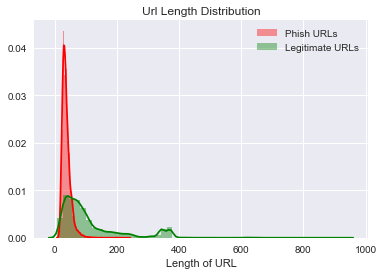

In [16]:
# Data Visualization, Distribution according to length of URL
sns.set(style = 'darkgrid')
sns.distplot(featureSet[featureSet['label'] == 0.0][' url length '], color='red', label = 'Phish URLs')
sns.distplot(featureSet[featureSet['label'] == 1.0][' url length '], color='green', label = 'Legitimate URLs')
plt.title('Url Length Distribution')
plt.legend(loc = 'upper right')
plt.xlabel('Length of URL')

plt.show()

In [17]:
# Preparing for model training
featureSet = sklearn.utils.shuffle(featureSet)

In [18]:
# axis = 1 means drop by column
X = featureSet.drop(['label'], axis = 1).values # without label
Y = featureSet['label'].values # label
pd.DataFrame(X).head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,0.0,0.0,0.0,0.0,0.0,2.0,3.0,40.0,0.0,2.0,22.0,2.0,1.0,18.0,0.0,0.0
1,0.0,0.0,0.0,0.0,2.0,4.0,4.0,56.0,0.0,3.0,18.0,4.0,1.0,38.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,2.0,2.0,22.0,0.0,2.0,13.0,2.0,0.0,9.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,2.0,4.0,24.0,0.0,4.0,16.0,2.0,0.0,8.0,0.0,0.0
4,0.0,0.0,1.0,0.0,2.0,3.0,3.0,48.0,0.0,2.0,16.0,3.0,1.0,32.0,0.0,0.0


In [19]:
pd.DataFrame(Y).head()

,0
0,0.0
1,0.0
2,0.0
3,0.0
4,0.0


In [20]:
model = {"Decision Tree" : tree.DecisionTreeClassifier(max_depth=10),
         "Random Forest" : ensembleLearning.RandomForestClassifier(n_estimators=50),
         "Adaboost" : ensembleLearning.AdaBoostClassifier(n_estimators=50),
         "Gradient Boosting" : ensembleLearning.GradientBoostingClassifier(n_estimators=50),
         "GNB" : GaussianNB(),
         "Logistic Regression" : LogisticRegression()
}

In [21]:
X_train, X_test, Y_train, Y_test = cross_validation.train_test_split(X, Y , test_size = (1 - cut_ratio))

Decision Tree : 0.891714285714 
Got 6242 out of 7000
f1 = 0.89
precision = 0.94
recall = 0.84
accuracy = 0.89


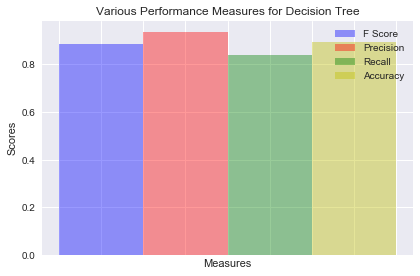

Random Forest : 0.900571428571 
Got 6304 out of 7000
f1 = 0.90
precision = 0.92
recall = 0.88
accuracy = 0.90


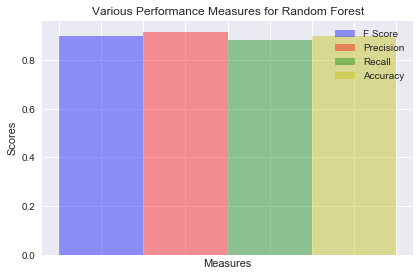

Adaboost : 0.879857142857 
Got 6159 out of 7000
f1 = 0.88
precision = 0.90
recall = 0.85
accuracy = 0.88


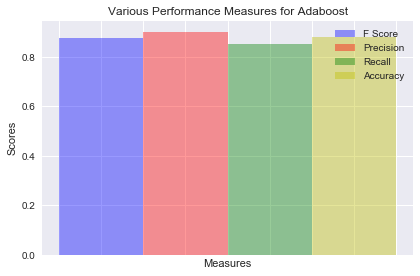

Gradient Boosting : 0.884285714286 
Got 6190 out of 7000
f1 = 0.88
precision = 0.90
recall = 0.87
accuracy = 0.88


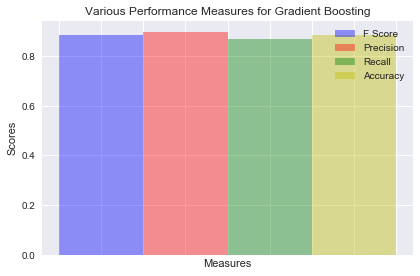

GNB : 0.775428571429 
Got 5428 out of 7000
f1 = 0.72
precision = 0.95
recall = 0.58
accuracy = 0.78


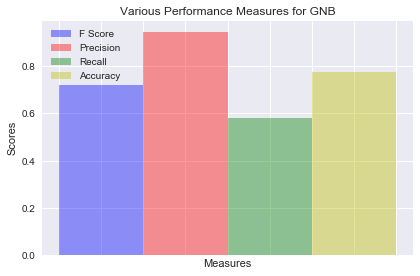

Logistic Regression : 0.827857142857 
Got 5795 out of 7000
f1 = 0.82
precision = 0.87
recall = 0.77
accuracy = 0.83


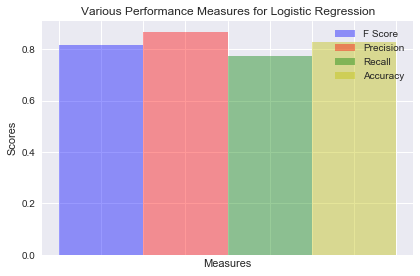

In [22]:
results = {}

for algo in model:
    clf = model[algo]
    clf.fit(X_train, Y_train)
    score = clf.score(X_test, Y_test)
    print ("%s : %s " %(algo, score))
    results[algo] = score
    
    Y_predict = clf.predict(X_test)
    get_f1_score(Y_test, Y_predict, "Various Performance Measures for %s"%algo)

In [23]:
winner = max(results, key = results.get)
print("Best Classifier : " + winner)

Best Classifier : Random Forest


In [24]:
clf = model[winner]
res = clf.predict(X)
con_matrix = confusion_matrix(Y, res)
print("False positive rate : %f %%" % ((con_matrix[0][1] / float(sum(con_matrix[0])))*100))
print('False negative rate : %f %%' % ((con_matrix[1][0] / float(sum(con_matrix[1]))*100)))

False positive rate : 2.895075 %
False negative rate : 6.127807 %


In [25]:
url = dfRequired[['domain']].iloc[from_index:to_index, 0]
url.head()

30000    prades-consulting.com/www.paypal.fr/bd6e020e9c...
30001                                  arcot6.mcscsec.com/
30002    'aricilikmarketi.com/templates/estime_redberry...
30003    www.cocodelagalea.es/imagenes/www.vodafone.co....
30004    bankruptcyarmor.com/wp-includes/js/crop/www.vo...
Name: domain, dtype: object

In [26]:
label = dfRequired[['label']].iloc[from_index:to_index, 0]
label.head()

30000    1.0
30001    1.0
30002    1.0
30003    1.0
30004    1.0
Name: label, dtype: float64

In [27]:
print("Total Count : " + str(len(label)))

Total Count : 35000


In [28]:
features_and_labels = make_feature_vector(from_index, url, label)
df_features_and_labels = pd.DataFrame(features_and_labels)
df_features_and_labels.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
0,0,0,1,0,0,3,3,69,0,1,21,3,2,48,0,0,1.0
1,0,0,0,0,0,1,2,19,0,2,18,1,0,1,0,0,1.0
2,0,0,0,0,1,5,2,86,0,1,20,5,1,66,0,0,1.0
3,0,0,0,0,0,3,6,57,0,2,20,3,4,37,0,0,1.0
4,0,0,1,0,0,5,5,67,0,1,19,5,4,48,0,0,1.0


In [29]:
len(features_and_labels)

35000

In [30]:
features_and_labels = np.array(features_and_labels)
random.shuffle(features_and_labels)

cut = int(len(features_and_labels) * cut_ratio)
XY_train = features_and_labels[:cut]
XY_test = features_and_labels[cut:]

df_features_and_labels = pd.DataFrame(features_and_labels)
df_features_and_labels.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
0,0.0,0.0,1.0,0.0,0.0,3.0,3.0,69.0,0.0,1.0,21.0,3.0,2.0,48.0,0.0,0.0,1.0
1,0.0,0.0,0.0,0.0,0.0,1.0,2.0,19.0,0.0,2.0,18.0,1.0,0.0,1.0,0.0,0.0,1.0
2,0.0,0.0,1.0,0.0,0.0,3.0,3.0,69.0,0.0,1.0,21.0,3.0,2.0,48.0,0.0,0.0,1.0
3,0.0,0.0,0.0,0.0,0.0,1.0,2.0,19.0,0.0,2.0,18.0,1.0,0.0,1.0,0.0,0.0,1.0
4,0.0,0.0,0.0,0.0,0.0,1.0,2.0,19.0,0.0,2.0,18.0,1.0,0.0,1.0,0.0,0.0,1.0


In [31]:
X_train, Y_train = make_np_array_XY(XY_train)
X_test, Y_test = make_np_array_XY(XY_test)
pd.DataFrame(X_train).head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,0.0,0.0,1.0,0.0,0.0,3.0,3.0,69.0,0.0,1.0,21.0,3.0,2.0,48.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,1.0,2.0,19.0,0.0,2.0,18.0,1.0,0.0,1.0,0.0,0.0
2,0.0,0.0,1.0,0.0,0.0,3.0,3.0,69.0,0.0,1.0,21.0,3.0,2.0,48.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,1.0,2.0,19.0,0.0,2.0,18.0,1.0,0.0,1.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,1.0,2.0,19.0,0.0,2.0,18.0,1.0,0.0,1.0,0.0,0.0


In [32]:
pd.DataFrame(Y_train).head()

,0
0,1.0
1,1.0
2,1.0
3,1.0
4,1.0


In [33]:
len(X_train)

28000

In [34]:
len(Y_train)

28000

In [35]:
#SVM SVC Classifier with Linear Kernel
C = 1.0  # SVM regularization parameter
svc = svm.SVC(kernel = 'linear', C = C).fit(X_train, Y_train)

In [36]:
# Predicted Label
Y_predict = svc.predict(X_test)
(pd.DataFrame(Y_predict)).head()

,0
0,1.0
1,1.0
2,1.0
3,1.0
4,1.0


In [37]:
# Actual Label
(pd.DataFrame(Y_test)).head()

,0
0,1.0
1,1.0
2,0.0
3,0.0
4,1.0


Got 4054 out of 7000
f1 = 0.73
precision = 0.58
recall = 1.00
accuracy = 0.58


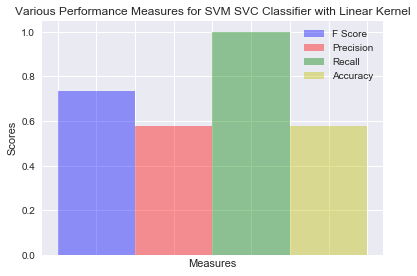

In [38]:
get_f1_score(Y_test, Y_predict, "Various Performance Measures for SVM SVC Classifier with Linear Kernel")